유튜브 SHAP 예제

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgboost

import shap
shap.initjs()   # SHAP 라이브러리가 그래프를 그릴 때 초기화 코드를 실행 #노트북 환경에서 깔끔한 그래프 출력을 위해 필수

c:\Users\kepco201\Desktop\SHAP_Project\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dataset 불러오기 -- pandas

In [ ]:
data = pd.read_csv(".. /파일경로", names = ["열1", "열2", ... "열8"])

print(data)
data.head()

Feature engineering

In [ ]:
x = data["열 이름1"]
y = data["열 이름"]


### SHAP modeling

In [ ]:
#Train model 
model = xgb.XGBRegressor(objective = "reg:squarederror")
model.fit(x,y)

# Get predictions
y_pred = model.predict(x)

#Model evaluation
plt.figure(figsize=(5,5))

#prediction
plt.scatter(y,y_pred)

In [ ]:
#비교용 y=x 그래프
plt.plot([0, 30], [0,30], color = 'r', linestyle='-', linewidth=2)

#축
plt.y_label('Predicted', size = 20)
plt.xlabel('Actual', size=20)



explainaer 정의하기

In [ ]:

# TreeExplainer는 XGBoost, LightGBM, RandomForest 같은 트리 기반 모델에 최적화된 설명 모델입니다.
explainer = shap.TreeExplainer(model)
# explainer(X_test)를 호출하여 SHAP 값, 데이터, 기본값 등이 모두 포함된 Explanation 객체를 생성합니다.
explanation = explainer(X_test)



np.shape(shap_values.values)

Plot하기 -- waterfall plot

In [ ]:
# waterfall plot for first observation
shap.plots.waterfall(shap_values[0])


force plot

In [ ]:
shap.plots.force(shap_values[0])

stacked force plots

In [ ]:
shap.plots.force(shap_values[0:100])

SHAP 예제

c:\Users\kepco201\Desktop\SHAP_Project\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


===== 1. Summary Plot (전체 피처 중요도) =====


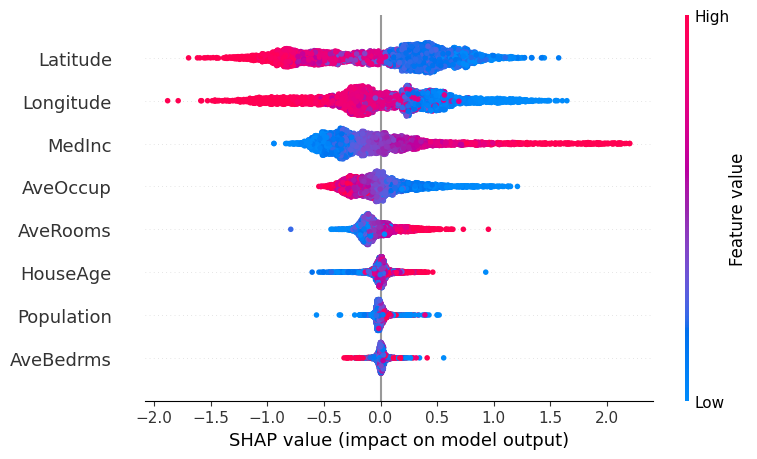


===== 2. Bar Plot (피처 중요도 순위) =====


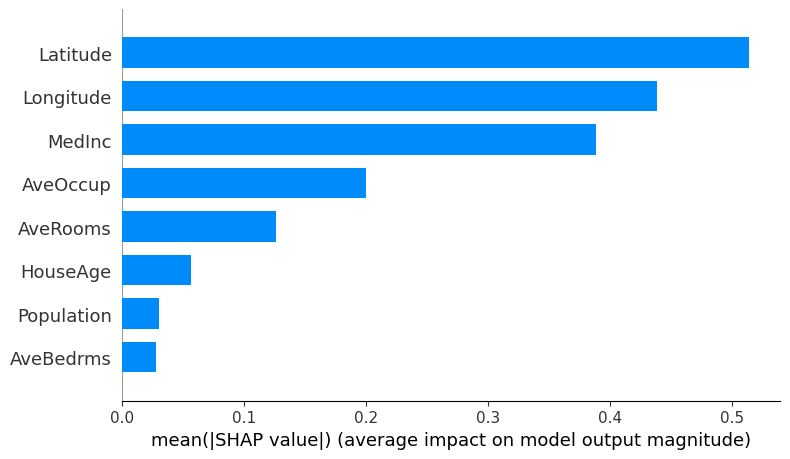


===== 3. Waterfall Plot (하나의 데이터 예측 과정 분석) =====


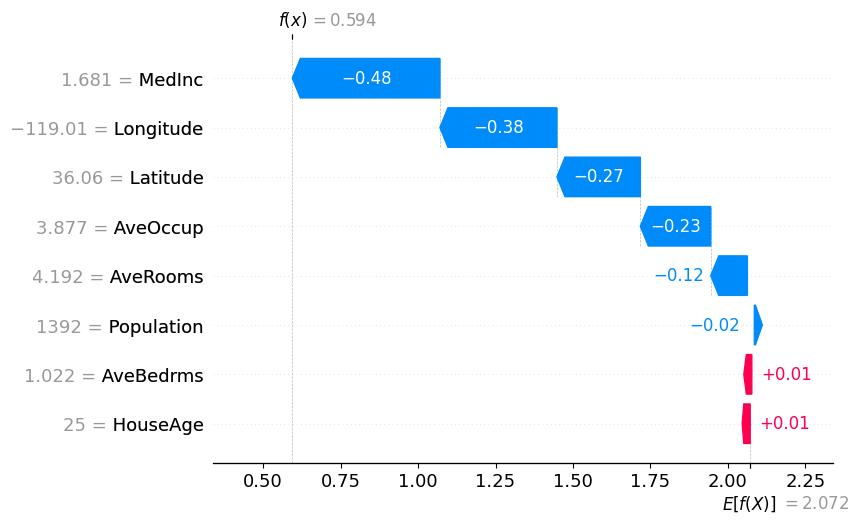


===== 4. Dependence Plot (특정 피처와 예측의 관계) =====


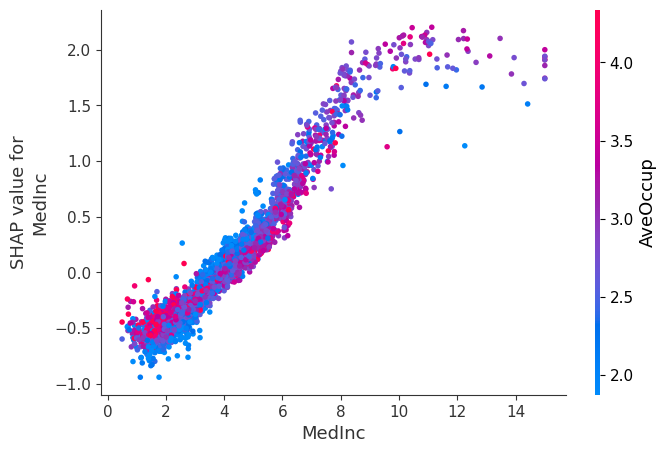

In [ ]:
# 2. 분석에 사용할 데이터를 불러옵니다.
# Scikit-learn에 내장된 '캘리포니아 주택 가격' 데이터셋을 사용합니다.
# 이 데이터는 각 지역의 특성(인구, 수입 등)을 바탕으로 주택 가격 중앙값을 예측하는 회귀 문제입니다.
X, y = shap.datasets.california()

# 데이터를 학습용과 테스트용으로 분리합니다.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. XGBoost 회귀 모델을 학습시킵니다.
model = xgboost.XGBRegressor()
model.fit(X_train, y_train)


# 4. SHAP Explainer를 생성하고 Explanation 객체를 계산합니다. 
# TreeExplainer는 XGBoost, LightGBM, RandomForest 같은 트리 기반 모델에 최적화된 설명 모델입니다.
explainer = shap.TreeExplainer(model)
# explainer(X_test)를 호출하여 SHAP 값, 데이터, 기본값 등이 모두 포함된 Explanation 객체를 생성합니다.
explanation = explainer(X_test)







# 5. SHAP 값 시각화를 통해 모델의 예측 결과를 해석합니다.


# (시각화 1) Summary Plot: 전체적인 피처(Feature) 중요도 확인하기
print("===== 1. Summary Plot (전체 피처 중요도) =====")
# Explanation 객체를 바로 전달하면 됩니다.
shap.summary_plot(explanation, X_test)


# -------------------------------------------------------------------
# (시각화 2) Summary Plot (Bar Chart): 피처 중요도를 막대그래프로 확인하기
print("\n===== 2. Bar Plot (피처 중요도 순위) =====")
# plot_type만 지정해주면 됩니다.
shap.summary_plot(explanation, plot_type="bar")


# -------------------------------------------------------------------
# (시각화 3) Waterfall Plot: 하나의 특정 예측을 상세히 분석하기
print("\n===== 3. Waterfall Plot (하나의 데이터 예측 과정 분석) =====")
# Explanation 객체에서 첫 번째 샘플([0])만 선택해서 전달하면 끝입니다.
# 기대값, SHAP 값, 피처 값을 따로 넣을 필요가 없습니다.
shap.waterfall_plot(explanation[0])


# -------------------------------------------------------------------
# (시각화 4) Dependence Plot: 특정 피처와 모델 예측 사이의 관계 확인하기
print("\n===== 4. Dependence Plot (특정 피처와 예측의 관계) =====")
# 이 플롯은 기존 방식과 거의 유사하게 사용할 수 있습니다.
shap.dependence_plot("MedInc", explanation.values, X_test)


SHAP 이용 CO2RR 공정 분석 시작